In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import copy
from typing import (
    Dict, 
    List,
    Any
)

import mlflow
from datetime import datetime


import numpy as np
import pandas as pd

from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

from joblib import load, dump

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
sys.path.append(os.path.join(os.getcwd(), '..'))
from utils.metrics import Metrics
from utils.modelling_tools import (
    search_hyper_params_and_log, 
    update_solver_by_penalty, 
    evaluate_model
)
from utils.metrics_by_quantile import MetricsByQuantile

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [5]:
RUN_NAME: str = '05-LogRegression-hyperparams_tunning'

In [14]:
PROJECT_PATH: str = os.path.join(os.getcwd(), '..')
DATA_PATH: str = os.path.join(PROJECT_PATH, 'data')
OPT_BIN_PATH: str = os.path.join(os.path.join(PROJECT_PATH, 'objects'), 'optbinners')
MODELS_PATH: str = os.path.join(os.path.join(PROJECT_PATH, 'objects'), 'models')

In [6]:
TRAIN_FROM: datetime.date = pd.to_datetime('2021-12-01').date()
TRAIN_TO: datetime.date = pd.to_datetime('2022-01-01').date()

VAL_FROM: datetime.date = pd.to_datetime('2022-01-01').date()
VAL_TO: datetime.date = pd.to_datetime('2022-05-01').date()

TEST_FROM: datetime.date = pd.to_datetime('2022-05-01').date()
TEST_TO: datetime.date = pd.to_datetime('2022-08-01').date()

In [7]:
# set constants
COLS_TO_USE: List[str] = [
"OPTIN_11SCN_MLOptBin",
"G5_ND_SPECIIOptBin",
"Marital_StatusOptBin",
"AFF_B_09_01OptBin",
"TRD_A_20OptBin",
"VM01_SP_VM2_15OptBin",
"SP_EDI_24OptBin",
"E4_Q_17OptBin",
"TRD_C_07OptBin",
"SP_B2_18OptBin",
"SPA_F2_33OptBin",
"VM01_SP_VM2_14OptBin",
"SP_G_38OptBin",
"TRD_O_05OptBin",
"E1_A_09OptBin",
"TRD_O_07OptBin",
"ND_INC_03OptBin",
"GEN11_SP_N_91OptBin",
"GEN11_SP_EDI_07OptBin",
"TRD_B_18OptBin",
"EA5_S_01OptBin",
"CLU_CLI_L6M_NPR_L6MOptBin",
"SP_I_67_01OptBin",
"GEN11_SP_K_80OptBin",
"ND_ECC_04OptBin",
"ND_ERL_01OptBin",
"ND_HAC_06OptBin",
"AFF_E_07_01OptBin",
"TRD_O_06OptBin",
"E2_G_08OptBin",
"AFF_T_07_01OptBin",
]

In [9]:
TARGET_NAME: str = 'GB6_Flag_2Limit'
TARGET_VALS: List[int] = [0, 1]
TARGET_BIN: str = f'_{TARGET_NAME}_bin'

PALETTE: Dict[str, str] = {
    TARGET_NAME: {
        'G': 'green',
        'B': 'red',
        'I': 'black'
    },
    TARGET_BIN: {0: 'green', 1: 'red'},
    'DataPart': {'Train+Val': 'black', 'Val': 'blue', 'Test': 'red', 'Train': 'orange'}
}

In [10]:
N_ITER: int = 100
RANDOM_SEED: int = 42
CONFIDENCE_LEVEL = 0.05

In [11]:
MODEL = LogisticRegression

In [12]:
PARAMS: Dict[str, Any] = dict(
    penalty=['l2', 'l1', 'elasticnet'], 
    C=uniform(loc=0, scale=20), 
    fit_intercept=[True], 
    class_weight=['balanced'], 
    random_state=[RANDOM_SEED], 
    n_jobs=[-1]
)

In [15]:
# read data
df: pd.DataFrame = pd.read_csv(os.path.join(DATA_PATH, 'final_aiq2_optbins.csv'), low_memory=False)

In [16]:
print('Number of rows: %.0f; columns: %.0f' % df.shape)

Number of rows: 110462; columns: 2069


# Preprocessing

Convert dates to the corresponding types

In [17]:
for col in ['_RDATE_EOM', '_RDATE']:
    df[col] = pd.to_datetime(df[col]).dt.date

In [18]:
print('Available date range:')
df['_RDATE'].agg(['min', 'max'])

Available date range:


min    2021-06-30
max    2023-11-30
Name: _RDATE, dtype: object

# Split data

In [19]:
df_train = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < TRAIN_TO) & 
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_val = df.loc[
    (df._RDATE >= VAL_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_test = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

In [21]:
data_dict = {
    "df_train": df_train,
    "df_val": df_val,
    "df_train_val": df_train_val, 
    "df_test_same": df_test_same,
    "df_test": df_test
}

In [22]:
# randomly select N observations from test data
N = 10000
sss = StratifiedShuffleSplit(n_splits=1, train_size=N, random_state=RANDOM_SEED)
indx = sss.split(data_dict['df_test_same'].reset_index(drop=True), data_dict['df_test_same'][TARGET_BIN])
random_indx = list(indx)[0][0]

assert len(random_indx) == N, "Incorrect number of elements in the subsample"
test_sample = data_dict['df_test_same'].reset_index(drop=True).iloc[random_indx, :].reset_index(drop=True)

In [23]:
data_dict['df_test_same_sample'] = test_sample

# Run the experiment

In [24]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
mlflow.set_experiment("[Experian][Initial]")

<Experiment: artifact_location='mlflow-artifacts:/778824721878270035', creation_time=1716819596783, experiment_id='778824721878270035', last_update_time=1716819596783, lifecycle_stage='active', name='[Experian][Initial]', tags={}>

In [26]:
experiment_description = f"""
    'features': {len(COLS_TO_USE)},
    'target': {TARGET_BIN},
    'target_vals': '0==G, 1==B',
    'model': {MODEL.__name__},
    'data_version': '22.05.2024', 
    'train_period': [{TRAIN_FROM.strftime('%Y-%m-%d') + ', ' + TRAIN_TO.strftime('%Y-%m-%d')}),
    'val_period': [{VAL_FROM.strftime('%Y-%m-%d') + ', ' + VAL_TO.strftime('%Y-%m-%d')}),
    'test_period': [{TEST_FROM.strftime('%Y-%m-%d') + ', ' + TEST_TO.strftime('%Y-%m-%d')}),
"""

In [27]:
print(experiment_description)


    'features': 31,
    'target': _GB6_Flag_2Limit_bin,
    'target_vals': '0==G, 1==B',
    'model': LogisticRegression,
    'data_version': '22.05.2024', 
    'train_period': [2021-12-01, 2022-01-01),
    'val_period': [2022-01-01, 2022-05-01),
    'test_period': [2022-05-01, 2022-08-01),



2024/05/27 20:18:30 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:18:30 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 1 / 100
# 2 / 100


2024/05/27 20:18:30 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:18:30 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 3 / 100
# 4 / 100


2024/05/27 20:18:41 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:18:41 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 5 / 100
# 6 / 100


2024/05/27 20:18:48 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/27 20:18:48 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 7 / 100


2024/05/27 20:18:54 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 20:18:54 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/05/27 20:18:54 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:18:54 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\s

# 8 / 100


2024/05/27 20:19:00 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 20:19:00 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/05/27 20:19:00 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/27 20:19:00 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\s

# 9 / 100


2024/05/27 20:19:06 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 20:19:06 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


# 10 / 100
# 11 / 100
# 12 / 100


2024/05/27 20:19:07 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:19:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 13 / 100
# 14 / 100


2024/05/27 20:19:14 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:19:14 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 15 / 100


2024/05/27 20:19:27 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 20:19:27 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/05/27 20:19:27 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:19:27 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\s

# 16 / 100


2024/05/27 20:19:33 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 20:19:33 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


# 17 / 100
# 18 / 100
# 19 / 100
# 20 / 100


2024/05/27 20:19:34 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:19:34 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 21 / 100
# 22 / 100
# 23 / 100
# 24 / 100


2024/05/27 20:19:41 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/27 20:19:41 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 25 / 100


2024/05/27 20:19:47 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 20:19:47 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


# 26 / 100
# 27 / 100
# 28 / 100


2024/05/27 20:19:48 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:19:48 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 29 / 100


2024/05/27 20:19:55 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/27 20:19:55 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 30 / 100
# 31 / 100


2024/05/27 20:20:01 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:20:01 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 32 / 100
# 33 / 100


2024/05/27 20:20:07 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:20:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 34 / 100
# 35 / 100
# 36 / 100
# 37 / 100
# 38 / 100
# 39 / 100


2024/05/27 20:20:14 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:20:14 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 40 / 100


2024/05/27 20:20:21 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 20:20:21 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


# 41 / 100
# 42 / 100
# 43 / 100
# 44 / 100
# 45 / 100
# 46 / 100
# 47 / 100


2024/05/27 20:20:22 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:20:22 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 48 / 100
# 49 / 100


2024/05/27 20:20:29 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:20:29 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 50 / 100
# 51 / 100
# 52 / 100
# 53 / 100
# 54 / 100
# 55 / 100
# 56 / 100
# 57 / 100


2024/05/27 20:20:37 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:20:37 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 58 / 100


    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metrics
    monitor.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\metrics\disk_monitor.py", line 15, in collect_metrics
    disk_usage = psutil.disk_usage(os.sep)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\psutil\__init__.py", line 2003, in disk_usage
    return _psplatform.disk_usage(path)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^


# 59 / 100


2024/05/27 20:20:51 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/27 20:20:51 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 60 / 100
# 61 / 100
# 62 / 100
# 63 / 100
# 64 / 100
# 65 / 100
# 66 / 100
# 67 / 100


2024/05/27 20:20:58 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/27 20:20:58 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 68 / 100
# 69 / 100
# 70 / 100
# 71 / 100


2024/05/27 20:21:05 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:21:05 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


# 72 / 100


    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metrics
    monitor.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\metrics\disk_monitor.py", line 15, in collect_metrics
    disk_usage = psutil.disk_usage(os.sep)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\psutil\__init__.py", line 2003, in disk_usage
    return _psplatform.disk_usage(path)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^


# 73 / 100


2024/05/27 20:21:12 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:21:12 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 74 / 100
# 75 / 100
# 76 / 100
# 77 / 100
# 78 / 100


2024/05/27 20:21:20 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/27 20:21:20 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 79 / 100
# 80 / 100
# 81 / 100


2024/05/27 20:21:27 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/27 20:21:27 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 82 / 100
# 83 / 100
# 84 / 100
# 85 / 100
# 86 / 100
# 87 / 100


2024/05/27 20:21:35 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/27 20:21:35 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 88 / 100


2024/05/27 20:21:42 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:21:42 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 89 / 100
# 90 / 100
# 91 / 100
# 92 / 100


2024/05/27 20:21:49 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:21:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 93 / 100
# 94 / 100


2024/05/27 20:21:56 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:21:56 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 95 / 100


2024/05/27 20:22:02 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 20:22:02 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


# 96 / 100
# 97 / 100


2024/05/27 20:22:02 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:22:02 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 98 / 100


Exception in thread 2024/05/27 20:22:08 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metrics
    monitor.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\metrics\disk_monitor.py", line 15, in collect_metri

# 99 / 100


2024/05/27 20:22:21 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 20:22:21 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/05/27 20:22:21 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 20:22:21 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\s

# 100 / 100


2024/05/27 20:22:27 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 20:22:27 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Best params:
 {'penalty': 'l1', 'C': 0.14132610439434812, 'fit_intercept': True, 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1, 'solver': 'liblinear'}
Val-PR_AUC:  0.13454678308160717
Val-GINI:  0.6814545242448693


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.


Not saved
Test-PR_AUC 0.13805166344889935
Test-Gini 0.6629721276265608


The option feature_dependence has been renamed to feature_perturbation!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


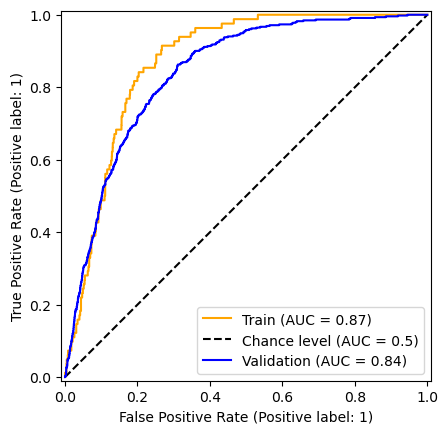

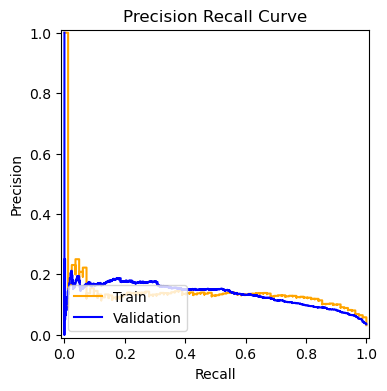

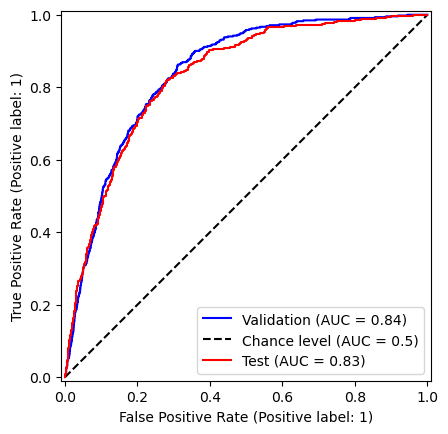

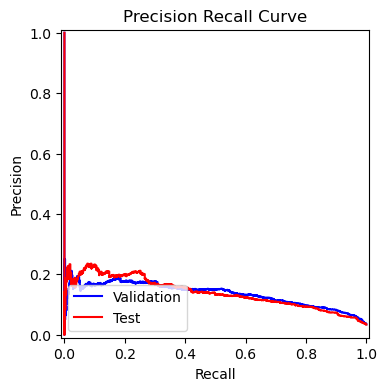

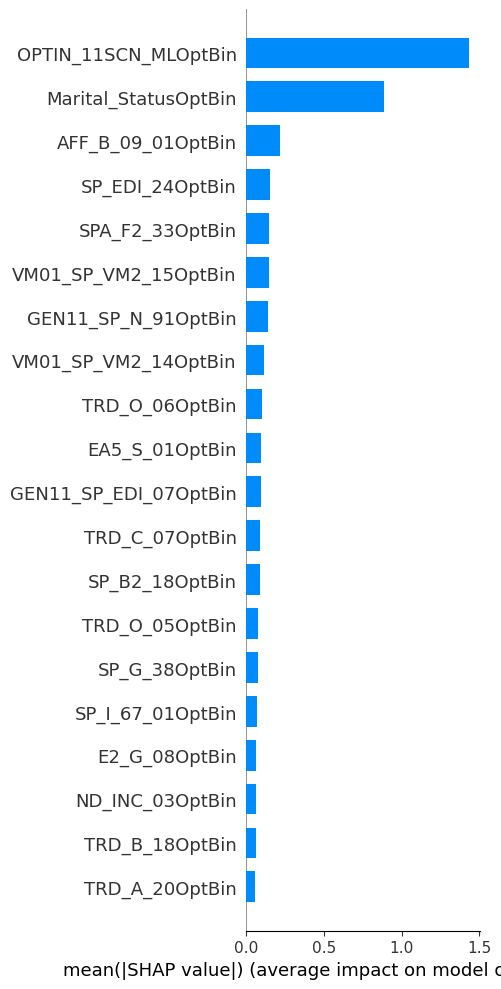

2024/05/27 20:22:40 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 20:22:40 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [29]:
with mlflow.start_run(run_name=RUN_NAME, log_system_metrics=True):
    res = search_hyper_params_and_log(
        run_name=RUN_NAME,
        data_dict=data_dict,
        cols_to_use=COLS_TO_USE,
        target_name=TARGET_BIN,
        distributions=PARAMS,
        n_iter=N_ITER,
        model=MODEL,
        custom_params_updates=update_solver_by_penalty,
        tags={'features': len(COLS_TO_USE)}, 
        palette=PALETTE['DataPart'],
        test_name='df_test_same',
        model_path=MODELS_PATH
    )

In [30]:
df_metrics, df_coeff, data_dict, model_obj, std_scaler = res

# Model's quality

## Coefficients

In [32]:
df_coeff.sort_values('Importance(%)', ascending=False)

,Feature,Coeff,Importance(%),p-value,Importance(SHAP),"Importance(SHAP, %)"
12,Intercept,-1.447595,20.037006,0.000000e+00,NaN,NaN
18,OPTIN_11SCN_MLOptBin,-1.107817,15.333940,0.000000e+00,1.433168,31.719690
13,Marital_StatusOptBin,-0.722082,9.994764,0.000000e+00,0.886865,19.628597
21,SP_EDI_24OptBin,-0.241039,3.336366,1.012638e-07,0.151100,3.344233
11,GEN11_SP_N_91OptBin,-0.227743,3.152324,3.699068e-09,0.136470,3.020442
0,AFF_B_09_01OptBin,0.217354,3.008527,8.082144e-06,0.217424,4.812161
27,TRD_O_05OptBin,-0.208055,2.879810,1.918687e-12,0.077289,1.710593
26,TRD_C_07OptBin,-0.201015,2.782366,3.509479e-08,0.089931,1.990404
7,EA5_S_01OptBin,-0.197767,2.737403,1.776357e-14,0.092584,2.049132
19,SPA_F2_33OptBin,-0.194352,2.690136,3.125168e-07,0.147479,3.264080


In [33]:
# features with 0 coefficients
df_coeff[df_coeff.Coeff == 0]

,Feature,Coeff,Importance(%),p-value,Importance(SHAP),"Importance(SHAP, %)"


In [34]:
# features with high p-value
df_coeff[df_coeff['p-value'] > CONFIDENCE_LEVEL]

,Feature,Coeff,Importance(%),p-value,Importance(SHAP),"Importance(SHAP, %)"
2,AFF_T_07_01OptBin,-0.048748,0.674746,0.074595,0.014394,0.318572
24,TRD_A_20OptBin,-0.057699,0.798640,0.089024,0.052586,1.163869


In [35]:
# features with p-values low than the confident level
for col in COLS_TO_USE:
    if col not in df_coeff[df_coeff['p-value'] > CONFIDENCE_LEVEL].Feature.values:
        print(f'"{col}",')

"OPTIN_11SCN_MLOptBin",
"G5_ND_SPECIIOptBin",
"Marital_StatusOptBin",
"AFF_B_09_01OptBin",
"VM01_SP_VM2_15OptBin",
"SP_EDI_24OptBin",
"E4_Q_17OptBin",
"TRD_C_07OptBin",
"SP_B2_18OptBin",
"SPA_F2_33OptBin",
"VM01_SP_VM2_14OptBin",
"SP_G_38OptBin",
"TRD_O_05OptBin",
"E1_A_09OptBin",
"TRD_O_07OptBin",
"ND_INC_03OptBin",
"GEN11_SP_N_91OptBin",
"GEN11_SP_EDI_07OptBin",
"TRD_B_18OptBin",
"EA5_S_01OptBin",
"CLU_CLI_L6M_NPR_L6MOptBin",
"SP_I_67_01OptBin",
"GEN11_SP_K_80OptBin",
"ND_ECC_04OptBin",
"ND_ERL_01OptBin",
"ND_HAC_06OptBin",
"AFF_E_07_01OptBin",
"TRD_O_06OptBin",
"E2_G_08OptBin",


## GINI, AU PRC

## Test-same

In [36]:
evaluate_model(
    data=data_dict['df_test_same'], 
    cols_to_use=COLS_TO_USE,
    std_scaler=std_scaler,
    target_name=TARGET_BIN,
    model_obj=model_obj
)

Test-PR_AUC 0.13805166344889935
Test-Gini 0.6629721276265608


## Test-full

In [37]:
evaluate_model(
    data=data_dict['df_test'], 
    cols_to_use=COLS_TO_USE,
    std_scaler=std_scaler,
    target_name=TARGET_BIN,
    model_obj=model_obj
)

Test-PR_AUC 0.11944916683675479
Test-Gini 0.6444213001899417


## Outcomes distributions

In [38]:
data_dict['df_test']['score'] = model_obj.predict_proba(
    std_scaler.transform(data_dict['df_test'][COLS_TO_USE])
)[:, 1]

### Test-same

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


<Axes: xlabel='score', ylabel='Density'>

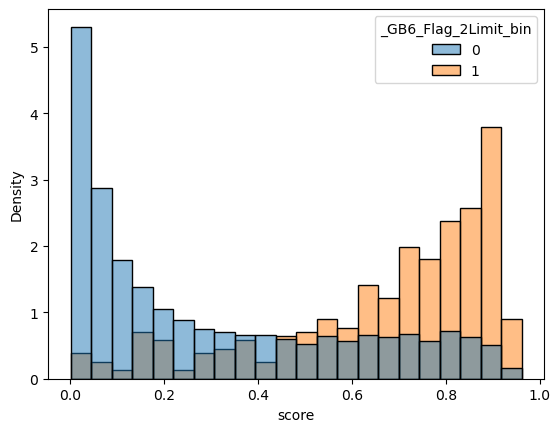

In [39]:
sns.histplot(x=data_dict['df_test_same']['score'], hue=data_dict['df_test_same'][TARGET_BIN], common_norm=False, stat='density')

### Test-full

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


<Axes: xlabel='score', ylabel='Density'>

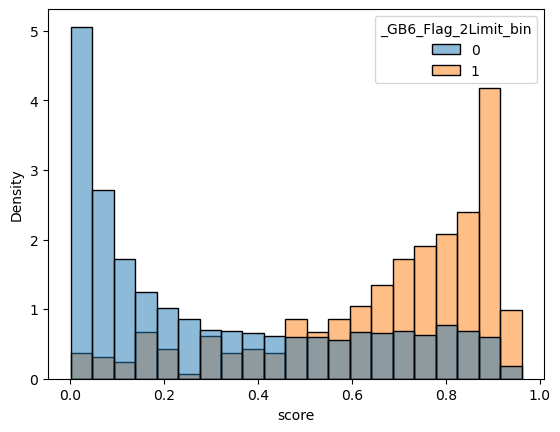

In [40]:
sns.histplot(x=data_dict['df_test']['score'], hue=data_dict['df_test'][TARGET_BIN], common_norm=False, stat='density')

## Precision, Recall By Quantile

### Test-same

In [41]:
m = MetricsByQuantile(metrics=["quantiles_analytics"])
r = m.compute(
    y_true=data_dict['df_test_same'][TARGET_BIN].reset_index(drop=True), 
    y_pred=data_dict['df_test_same']['score'].round(3).reset_index(drop=True), 
    list_of_metrics = [
        "cum_precision_by_quantile", "cum_recall_by_quantile", 
        "precision_by_quantile", "recall_by_quantile",
    ], 
    n_quantiles = 200
)
df_deciles = r["other"]["quantiles_analytics"]
df_deciles.head(50)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,% of total population,Cumulative % of total population,Total,Bad,Cumulative Bad,Quantile,#Quantile,Cumulative Precision,Cumulative Recall,Precision,Recall,Scores
0,0.51,0.51,54,9,9,"(0.927, 0.961]",193,16.666667,2.521008,16.666667,2.521008,0.927--0.961
1,0.49,1.00,52,13,22,"(0.912, 0.927]",192,20.754717,6.162465,25.000000,3.641457,0.912--0.927
2,0.47,1.47,50,14,36,"(0.904, 0.912]",191,23.076923,10.084034,28.000000,3.921569,0.904--0.912
3,0.46,1.93,49,5,41,"(0.898, 0.904]",190,20.000000,11.484594,10.204082,1.400560,0.898--0.904
4,0.48,2.40,51,12,53,"(0.89, 0.898]",189,20.703125,14.845938,23.529412,3.361345,0.89--0.898
5,0.54,2.95,58,9,62,"(0.881, 0.89]",188,19.745223,17.366947,15.517241,2.521008,0.881--0.89
6,0.49,3.44,52,11,73,"(0.874, 0.881]",187,19.945355,20.448179,21.153846,3.081232,0.874--0.881
7,0.56,4.00,60,17,90,"(0.866, 0.874]",186,21.126761,25.210084,28.333333,4.761905,0.866--0.874
8,0.45,4.45,48,5,95,"(0.858, 0.866]",185,20.042194,26.610644,10.416667,1.400560,0.858--0.866
9,0.54,5.00,58,2,97,"(0.85, 0.858]",184,18.233083,27.170868,3.448276,0.560224,0.85--0.858


### Test-full

In [42]:
m = MetricsByQuantile(metrics=["quantiles_analytics"])
r = m.compute(
    y_true=data_dict['df_test'][TARGET_BIN].reset_index(drop=True), 
    y_pred=data_dict['df_test']['score'].round(3).reset_index(drop=True), 
    list_of_metrics = [
        "cum_precision_by_quantile", "cum_recall_by_quantile", 
        "precision_by_quantile", "recall_by_quantile",
    ], 
    n_quantiles = 200
)
df_deciles = r["other"]["quantiles_analytics"]
df_deciles.head(50)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,% of total population,Cumulative % of total population,Total,Bad,Cumulative Bad,Quantile,#Quantile,Cumulative Precision,Cumulative Recall,Precision,Recall,Scores
0,0.48,0.48,54,8,8,"(0.928, 0.961]",193,14.814815,2.240896,14.814815,2.240896,0.928--0.961
1,0.51,0.99,58,11,19,"(0.914, 0.928]",192,16.964286,5.322129,18.965517,3.081232,0.914--0.928
2,0.48,1.47,54,13,32,"(0.906, 0.914]",191,19.277108,8.963585,24.074074,3.641457,0.906--0.914
3,0.49,1.96,55,8,40,"(0.9, 0.906]",190,18.099548,11.204482,14.545455,2.240896,0.9--0.906
4,0.49,2.44,55,7,47,"(0.894, 0.9]",189,17.028986,13.165266,12.727273,1.960784,0.894--0.9
5,0.54,2.98,61,8,55,"(0.886, 0.894]",188,16.320475,15.406162,13.114754,2.240896,0.886--0.894
6,0.46,3.44,52,10,65,"(0.879, 0.886]",187,16.709512,18.207283,19.230769,2.801120,0.879--0.886
7,0.51,3.96,58,11,76,"(0.872, 0.879]",186,17.002237,21.288515,18.965517,3.081232,0.872--0.879
8,0.53,4.49,60,14,90,"(0.865, 0.872]",185,17.751479,25.210084,23.333333,3.921569,0.865--0.872
9,0.47,4.96,53,5,95,"(0.857, 0.865]",184,16.964286,26.610644,9.433962,1.400560,0.857--0.865
